#Installing external libraries

In [103]:
!pip install -U scikit-fuzzy
!pip install ucimlrepo

#Importing Libraries

In [104]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import skfuzzy.membership as mf
import requests
import re
from skfuzzy import control as ctrl

#UCI Cleveland Heart Disease Dataset

https://archive.ics.uci.edu/dataset/45/heart+disease

In [4]:
from ucimlrepo import fetch_ucirepo

heart_disease = fetch_ucirepo(id=45)

# metadata
print(heart_disease.metadata)
# variable information
print(heart_disease.variables)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

In [5]:
X = heart_disease.data.features
Y = heart_disease.data.targets

In [6]:
Y.rename(columns={"num": "target"}, inplace=True)
Y

<ipython-input-6-c2732d7d0d9a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y.rename(columns={"num": "target"}, inplace=True)


,target
0,0
1,2
2,1
3,0
4,0
...,...
298,1
299,2
300,3
301,1


In [7]:
Y['target'] = Y.target.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})
Y

<ipython-input-7-7a89bab5b06a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['target'] = Y.target.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})


,target
0,0
1,1
2,1
3,0
4,0
...,...
298,1
299,1
300,1
301,1


In [8]:
X = X.fillna(0)
pd.isna(X).sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64

In [9]:
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0


#Performing ML Model Analysis

##Reading and preprocessing

In [10]:
df = pd.read_csv('/content/drive/MyDrive/College Documents/Expert Systems Project/cleveland.csv')

df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol',
              'fbs', 'restecg', 'thalach', 'exang',
              'oldpeak', 'slope', 'ca', 'thal', 'target']

In [11]:
df['target'] = df.target.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})
df['thal'] = df.thal.fillna(df.thal.mean())
df['ca'] = df.ca.fillna(df.ca.mean())

In [12]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
1,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
2,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
3,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
4,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [13]:
feature_names = ['age', 'sex', 'cp', 'trestbps', 'chol',
              'fbs', 'restecg', 'thalach', 'exang',
              'oldpeak', 'slope', 'ca', 'thal']

In [14]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

##Imports

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
from six import StringIO
import pydotplus

## Decision Tree (C4.5 like Algorithm using sklearn)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [17]:
clf = DecisionTreeClassifier(criterion="entropy")
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [18]:
y_pred = clf.predict(X_test)
y_pred

array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0])

In [19]:
print("Accuracy: ", accuracy_score(y_test, y_pred) * 100)

Accuracy:  77.04918032786885


In [20]:
matrix = confusion_matrix(y_test, y_pred)

In [21]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])

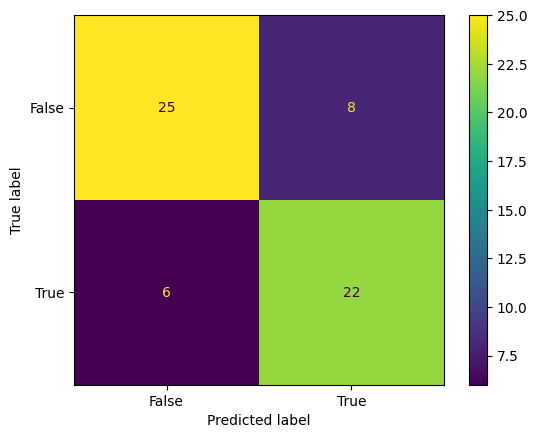

In [22]:
cm_display.plot()
plt.show()

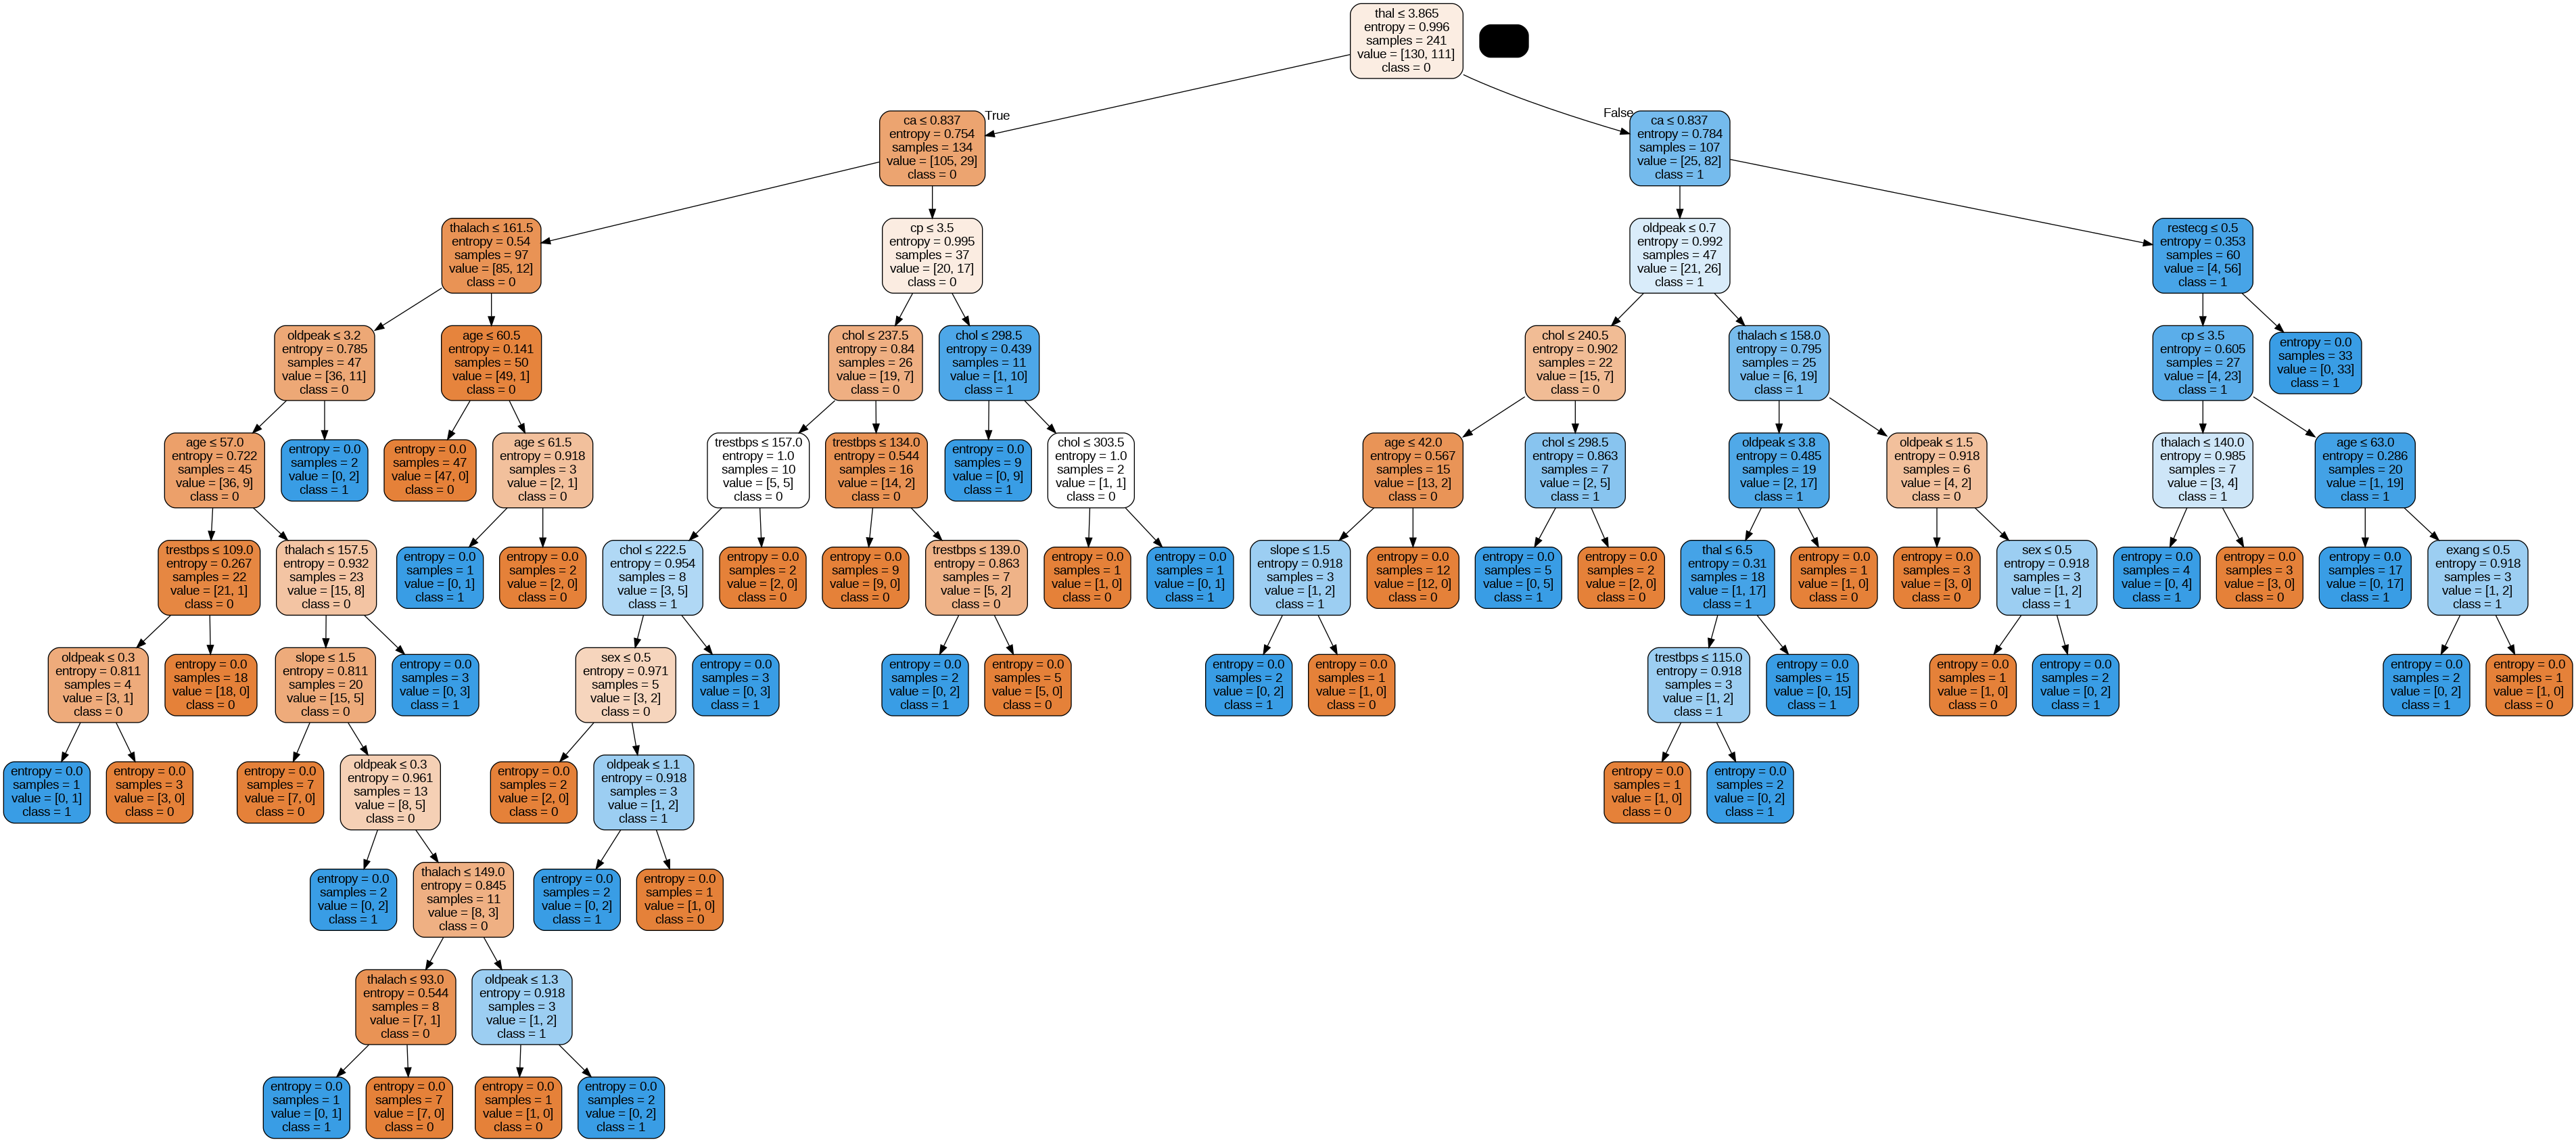

In [23]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_names, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('heart disease.png')
Image(graph.create_png())


## Random Forest

In [24]:
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [25]:
y_pred = rf.predict(X_test)
y_pred

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0])

In [26]:
print("Accuracy: ", accuracy_score(y_test, y_pred) * 100)

Accuracy:  78.68852459016394


In [27]:
matrix = confusion_matrix(y_pred, y_test)

In [28]:
cm_display2 = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])

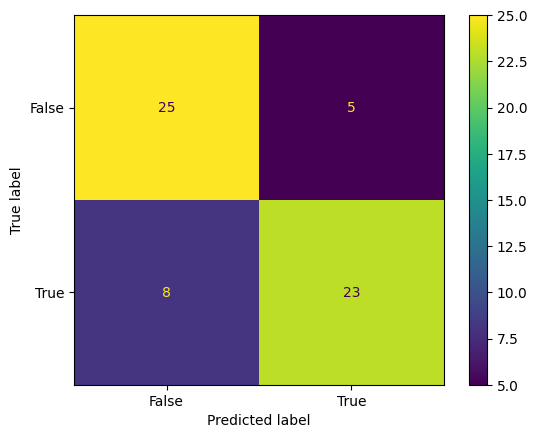

In [29]:
cm_display2.plot()
plt.show()

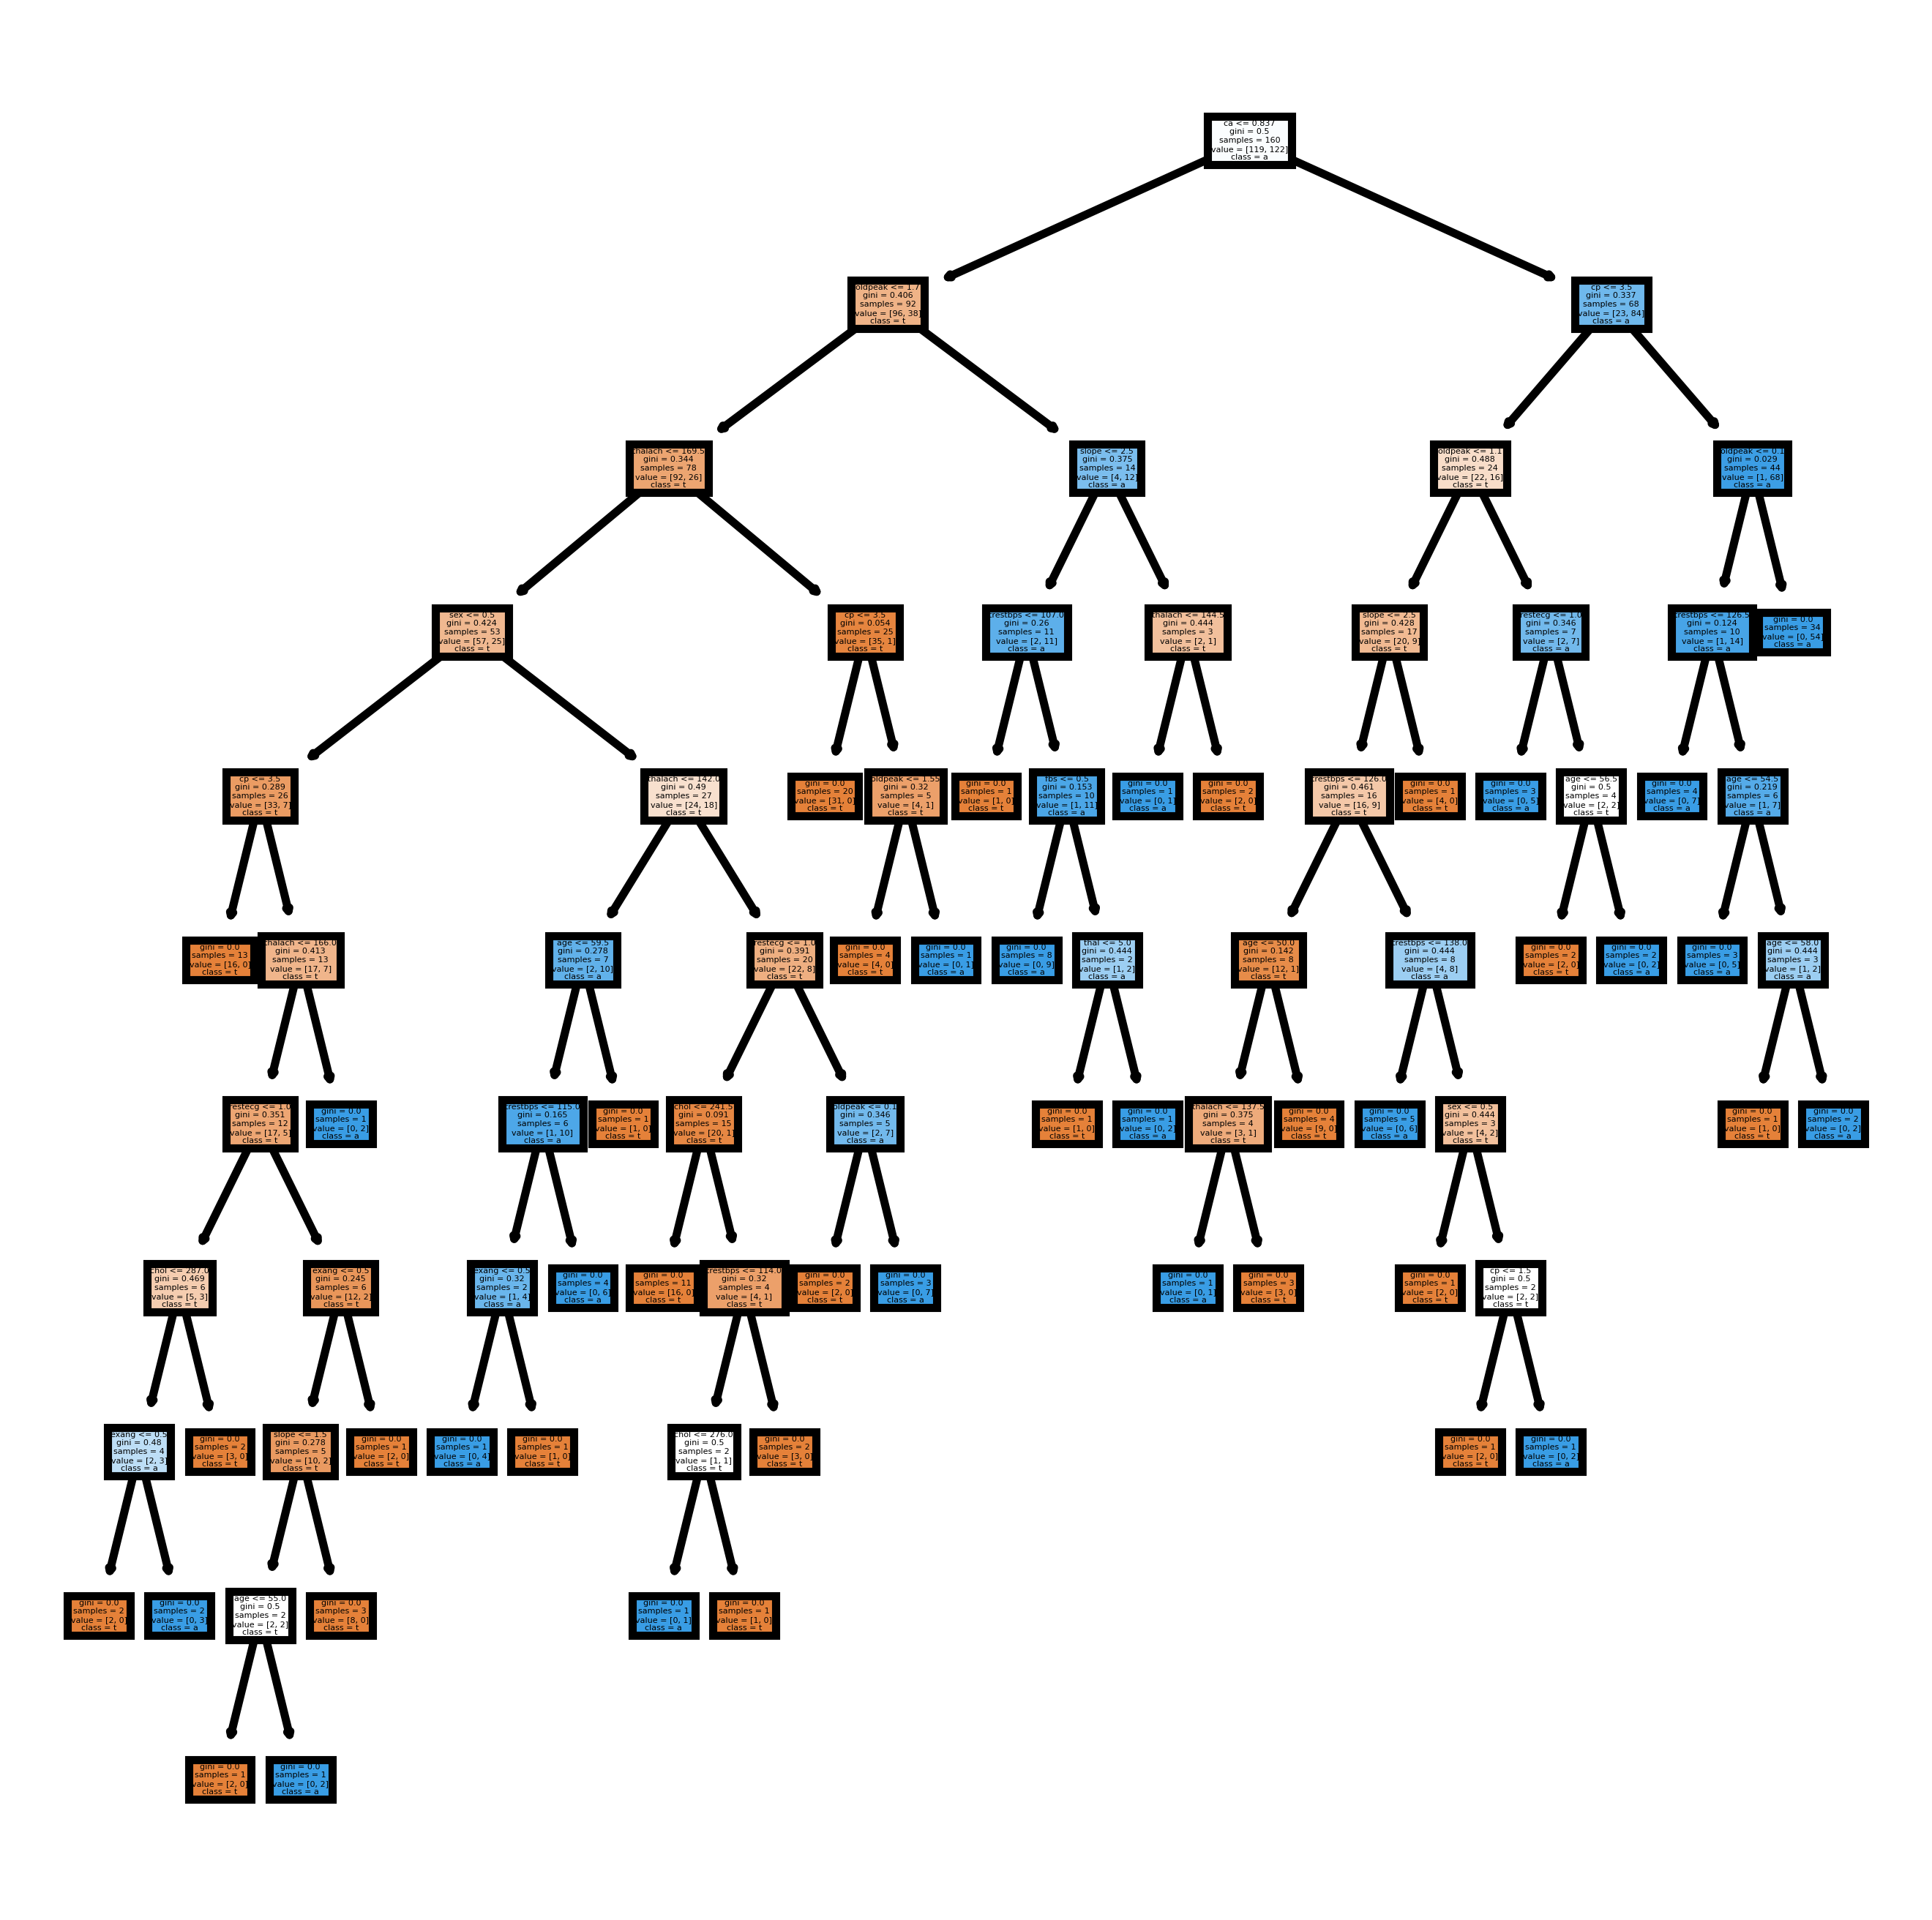

In [30]:
from sklearn import tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf.estimators_[0],
               feature_names = feature_names,
               class_names="target",
               filled = True);
fig.savefig('rf_individualtree.png')

# Saving each column in a variable

In [31]:
blood_pressure_crisp_values1 = df['trestbps'].values
blood_pressure_crisp_values1

array([160, 120, 130, 130, 120, 140, 120, 130, 140, 140, 140, 130, 120,
       172, 150, 110, 140, 130, 130, 110, 150, 120, 132, 130, 120, 120,
       150, 150, 110, 140, 117, 140, 135, 130, 140, 120, 150, 132, 150,
       150, 140, 160, 150, 130, 112, 110, 150, 140, 130, 105, 120, 112,
       130, 130, 124, 140, 110, 125, 125, 130, 142, 128, 135, 120, 145,
       140, 150, 170, 150, 155, 125, 120, 110, 110, 160, 125, 140, 130,
       150, 104, 130, 140, 180, 120, 140, 138, 128, 138, 130, 120, 160,
       130, 108, 135, 128, 110, 150, 134, 122, 115, 118, 128, 110, 120,
       108, 140, 128, 120, 118, 145, 125, 118, 132, 130, 135, 140, 138,
       130, 135, 130, 150, 100, 140, 138, 130, 200, 110, 120, 124, 120,
        94, 130, 140, 122, 135, 145, 120, 120, 125, 140, 170, 128, 125,
       105, 108, 165, 112, 128, 102, 152, 102, 115, 160, 120, 130, 140,
       125, 140, 118, 101, 125, 110, 100, 124, 132, 138, 132, 126, 112,
       160, 142, 174, 140, 145, 152, 108, 132, 130, 130, 124, 13

In [32]:
blood_pressure_crisp_values1 = df['trestbps'].values
cholesterol_crisp_values1 = df['chol'].values
age_crisp_values1 = df['age'].values
sex_crisp_values1 = df['sex'].values
chest_pain_crisp_values1 = df['cp'].values
ecg_crisp_values1 = df['restecg'].values
blood_sugar_crisp_values1 = df['fbs'].values
max_heart_rate_crisp_values1 = df['thalach'].values
thallium_crisp_values1 = df['thal'].values
exercise_crisp_values1 = df['exang'].values
old_peak_crisp_values1 = df['oldpeak'].values

In [33]:
# blood_pressure_crisp_values = X['trestbps'].values
# cholesterol_crisp_values = X['chol'].values
# age_crisp_values = X['age'].values
# sex_crisp_values = X['sex'].values
# chest_pain_crisp_values = X['cp'].values
# ecg_crisp_values = X['restecg'].values
# blood_sugar_crisp_values = X['fbs'].values
# max_heart_rate_crisp_values = X['thalach'].values
# thallium_crisp_values = X['thal'].values
# exercise_crisp_values = X['exang'].values
# old_peak_crisp_values = X['oldpeak'].values

#Defining the variables' membership functions and plotting graphs for them

##Input Variables

###crisp sets can be defined with dictionaries or membership functions

In [34]:
chest_pain_values = { 'typical_anginal': 1, 'atypical_anginal': 2, 'non_aginal_pain': 3, 'asymptomatic': 4 }

def define_chest_pain_membership(chest_pain_values):
    typical_anginal = fuzz.trimf(chest_pain_values, [1, 1, 2])
    atypical_anginal = fuzz.trimf(chest_pain_values, [2, 2, 3])
    non_aginal_pain = fuzz.trimf(chest_pain_values, [3, 3, 4])
    asymptomatic = fuzz.trimf(chest_pain_values, [4, 4, 5])
    return {'typical_anginal': typical_anginal, 'atypical_anginal': atypical_anginal, 'non_aginal_pain': non_aginal_pain, 'asymptomatic': asymptomatic}

In [35]:
exercise_values = { 'true': 1, 'false': 0 }

def define_exercise_membership(exercise_values):
    true_membership = fuzz.trimf(exercise_values, [1, 1, 1])
    false_membership = fuzz.trimf(exercise_values, [0, 0, 0])
    return {'true': true_membership, 'false': false_membership}

In [36]:
thallium_scan_values = { 'normal': 3, 'fixed_defect': 6, 'reversible_defect': 7 }

def define_thallium_scan_membership(thallium_scan_values):
    normal_membership = fuzz.trimf(thallium_scan_values, [3, 3, 4])
    fixed_defect_membership = fuzz.trimf(thallium_scan_values, [6, 6, 7])
    reversible_defect_membership = fuzz.trimf(thallium_scan_values, [7, 7, 8])
    return {'normal': normal_membership, 'fixed_defect': fixed_defect_membership, 'reversible_defect': reversible_defect_membership}

In [37]:
sex_values = { 'female': 1, 'male': 0 }

def define_sex_membership(sex_values):
  female_membership = fuzz.trimf(sex_values, [0, 0, 1])
  male_membership = fuzz.trimf(sex_values, [1, 1, 2])
  return {'female': female_membership, 'male': male_membership}

###fuzzy sets are defined with membership functions

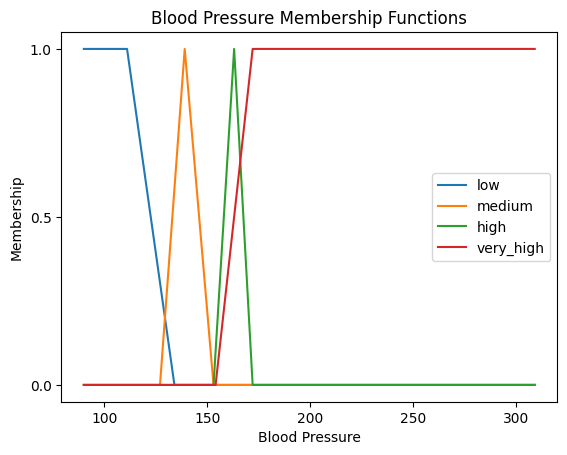

In [38]:
def define_blood_pressure_membership(blood_pressure):
    low = fuzz.trapmf(blood_pressure, [80, 80, 111, 134])
    medium = fuzz.trimf(blood_pressure, [127, 139, 153])
    high = fuzz.trimf(blood_pressure, [153, 163, 172])
    very_high = fuzz.trapmf(blood_pressure, [154, 172, 310, 310])

    return {'low': low, 'medium': medium, 'high': high, 'very_high': very_high}

blood_pressure_values = np.arange(90, 310, 1)
blood_pressure_membership_functions = define_blood_pressure_membership(blood_pressure_values)

# Plot the membership functions
for label, membership_function in blood_pressure_membership_functions.items():
    plt.plot(blood_pressure_values, membership_function, label=label)

plt.title('Blood Pressure Membership Functions')
plt.xlabel('Blood Pressure')
plt.ylabel('Membership')
plt.yticks(np.arange(0, 1.1, 0.5))
plt.legend()
plt.show()

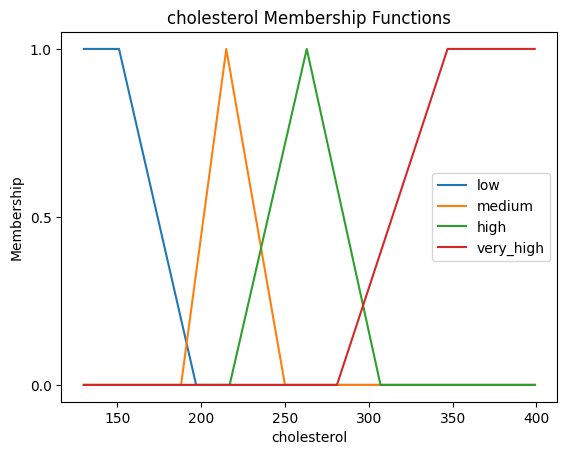

In [39]:
def define_cholesterol_membership(cholesterol):
    low = fuzz.trapmf(cholesterol, [80, 80, 151, 197])
    medium = fuzz.trimf(cholesterol, [188, 215, 250])
    high = fuzz.trimf(cholesterol, [217, 263, 307])
    very_high = fuzz.trapmf(cholesterol, [281, 347, 400, 400])

    return {'low': low, 'medium': medium, 'high': high, 'very_high': very_high}

cholesterol_values = np.arange(130, 400, 1)
cholesterol_membership_functions = define_cholesterol_membership(cholesterol_values)

# Plot the membership functions
for label, membership_function in cholesterol_membership_functions.items():
    plt.plot(cholesterol_values, membership_function, label=label)

plt.title('cholesterol Membership Functions')
plt.xlabel('cholesterol')
plt.ylabel('Membership')
plt.yticks(np.arange(0, 1.1, 0.5))
plt.legend()
plt.show()

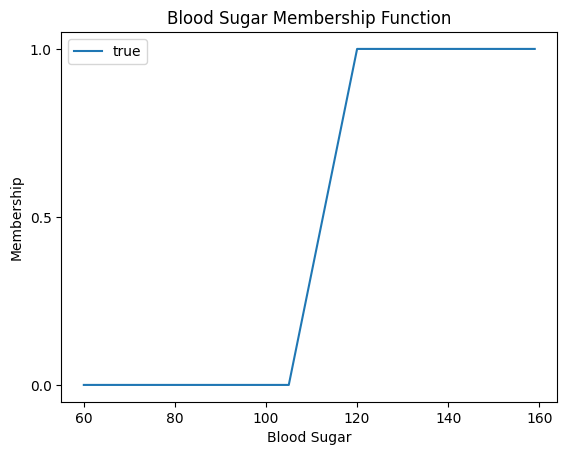

In [40]:
def define_blood_sugar_membership(blood_sugar):
    very_high = fuzz.trapmf(blood_sugar, [105, 120, 400, 400])
    not_very_high = fuzz.trapmf(blood_sugar, [0, 0, 105, 120])

    return {'true': very_high, 'false' : not_very_high}

blood_sugar_values = np.arange(60, 160, 1)
blood_sugar_membership_functions = define_blood_sugar_membership(blood_sugar_values)

# Plot the membership functions
plt.plot(blood_sugar_values, blood_sugar_membership_functions['true'], label='true')

plt.title('Blood Sugar Membership Function')
plt.xlabel('Blood Sugar')
plt.ylabel('Membership')
plt.yticks(np.arange(0, 1.1, 0.5))
plt.legend()
plt.show()

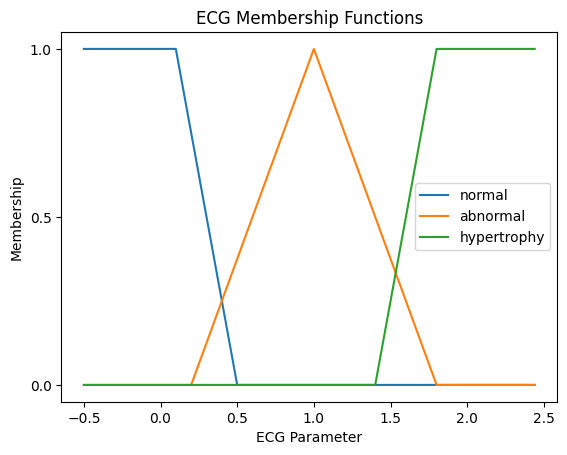

In [41]:
def define_ecg_membership(ecg):
    normal = fuzz.trapmf(ecg, [-0.5, -0.5, 0.1, 0.5])
    abnormal = fuzz.trimf(ecg, [0.2, 1, 1.8])
    hypertrophy = fuzz.trapmf(ecg, [1.4, 1.8, 2.45, 2.45])

    return {'normal': normal, 'abnormal': abnormal, 'hypertrophy': hypertrophy}

ecg_values = np.arange(-0.5, 2.45, 0.01)
ecg_membership_functions = define_ecg_membership(ecg_values)

# Plot the membership functions
for label, membership_function in ecg_membership_functions.items():
    plt.plot(ecg_values, membership_function, label=label)

plt.title('ECG Membership Functions')
plt.xlabel('ECG Parameter')
plt.ylabel('Membership')
plt.yticks(np.arange(0, 1.1, 0.5))
plt.legend()
plt.show()

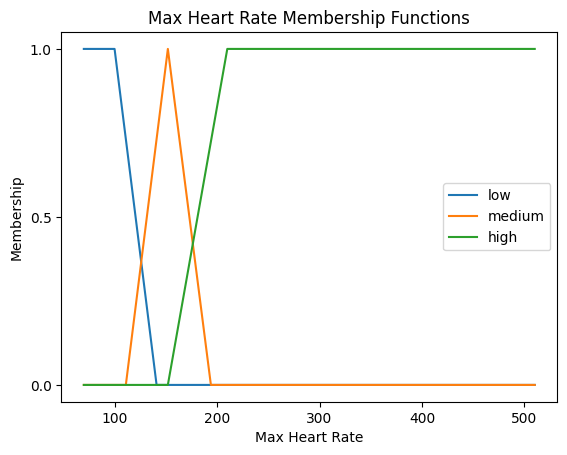

In [42]:
def define_max_heart_rate_membership(max_heart_rate):
    low = fuzz.trapmf(max_heart_rate, [70, 70, 100, 141])
    medium = fuzz.trimf(max_heart_rate, [111, 152, 194])
    high = fuzz.trapmf(max_heart_rate, [152, 210, 510, 510])

    return {'low': low, 'medium': medium,'high': high}

max_heart_rate_values = np.arange(70, 511, 1)
max_heart_rate_membership_functions = define_max_heart_rate_membership(max_heart_rate_values)

# Plot the membership functions
for label, membership_function in max_heart_rate_membership_functions.items():
    plt.plot(max_heart_rate_values, membership_function, label=label)

# # Adjust the range for 'low' to form a trapezium
# low_range = np.arange(70, 141, 1)
# low_triangle = fuzz.trapmf(low_range, [70, 70, 100, 141])
# plt.plot(low_range, low_triangle, label='low', color = "b")

# # Adjust the range for 'medium' to form a triangle
# medium_range = np.arange(111, 195, 1)
# medium_triangle = fuzz.trimf(medium_range, [111, 152, 194])
# plt.plot(medium_range, medium_triangle, label='medium', color = "g")

plt.title('Max Heart Rate Membership Functions')
plt.xlabel('Max Heart Rate')
plt.ylabel('Membership')
plt.yticks(np.arange(0, 1.1, 0.5))
plt.legend()
plt.show()

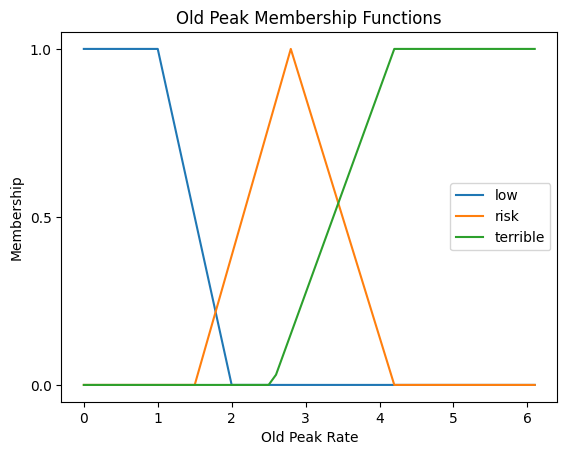

In [43]:
def define_old_peak_membership(old_peak):
    low = fuzz.trapmf(old_peak, [0, 0, 1, 2])
    risk = fuzz.trimf(old_peak, [1.5, 2.8, 4.2])
    terrible = fuzz.trapmf(old_peak, [2.55, 4.2, 6.2, 6.2])

    return {'low': low, 'risk': risk,'terrible': terrible}

old_peak_values = np.arange(0, 6.2, 0.1)
old_peak_membership_functions = define_old_peak_membership(old_peak_values)

# Plot the membership functions
for label, membership_function in old_peak_membership_functions.items():
    plt.plot(old_peak_values, membership_function, label=label)

plt.title('Old Peak Membership Functions')
plt.xlabel('Old Peak Rate')
plt.ylabel('Membership')
plt.yticks(np.arange(0, 1.1, 0.5))
plt.legend()
plt.show()


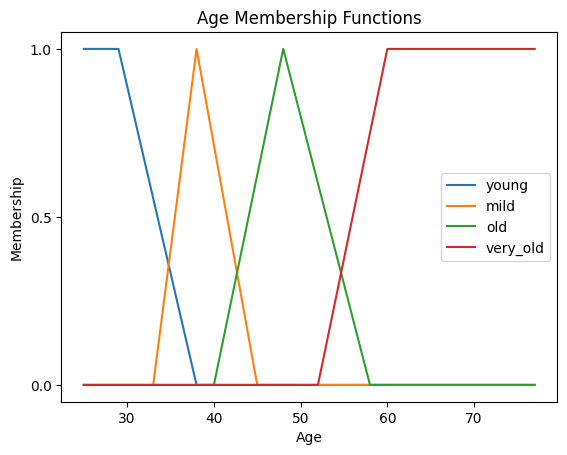

In [44]:
def define_age_membership(age):
    young = fuzz.trapmf(age, [25, 25, 29, 38])
    mild = fuzz.trimf(age, [33, 38, 45])
    old = fuzz.trimf(age, [40, 48, 58])
    very_old = fuzz.trapmf(age, [52, 60, 78, 78])

    return {'young': young, 'mild': mild, 'old': old, 'very_old' : very_old}

age_values = np.arange(25, 78, 1)
age_membership_functions = define_age_membership(age_values)

# Plot the membership functions
for label, membership_function in age_membership_functions.items():
    plt.plot(age_values, membership_function, label=label)

plt.title('Age Membership Functions')
plt.xlabel('Age')
plt.ylabel('Membership')
plt.yticks(np.arange(0, 1.1, 0.5))
plt.legend()
plt.show()

##Output Variable

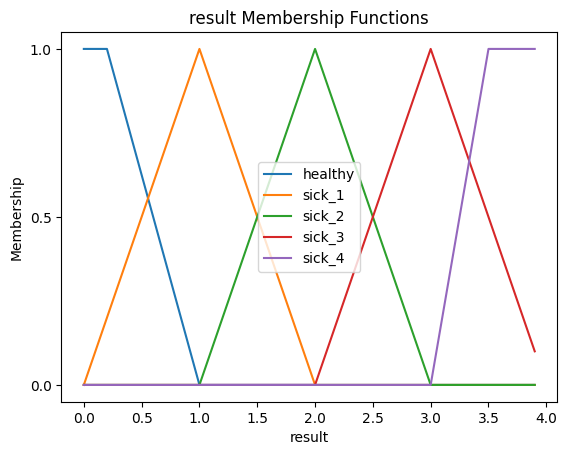

In [45]:
def define_result_membership(result):
    healthy = fuzz.trapmf(result, [0, 0, 0.2, 1])
    sick_1 = fuzz.trimf(result, [0, 1, 2])
    sick_2 = fuzz.trimf(result, [1, 2, 3])
    sick_3 = fuzz.trimf(result, [2, 3, 4])
    sick_4 = fuzz.trapmf(result, [3, 3.5, 4, 4])

    return {'healthy': healthy, 'sick_1': sick_1, 'sick_2': sick_2, 'sick_3': sick_3, 'sick_4': sick_4 }

result_values = np.arange(0, 4, 0.1)
result_membership_functions = define_result_membership(result_values)

# Plot the membership functions
for label, membership_function in result_membership_functions.items():
    plt.plot(result_values, membership_function, label=label)

plt.title('result Membership Functions')
plt.xlabel('result')
plt.ylabel('Membership')
plt.yticks(np.arange(0, 1.1, 0.5))
plt.legend()
plt.show()

#Designing Fuzzy System

In [105]:
# Define the input variables
age = ctrl.Antecedent(np.arange(0, 101, 1), 'age')
chest_pain = ctrl.Antecedent(np.arange(0, 11, 1), 'chest_pain')
maximum_heart_rate = ctrl.Antecedent(np.arange(0, 231, 1), 'maximum_heart_rate')
sex = ctrl.Antecedent(np.arange(0, 2, 1), 'sex')
blood_pressure = ctrl.Antecedent(np.arange(0, 201, 1), 'blood_pressure')
blood_sugar = ctrl.Antecedent(np.arange(0, 2, 1), 'blood_sugar')
cholesterol = ctrl.Antecedent(np.arange(0, 201, 1), 'cholesterol')
ECG = ctrl.Antecedent(np.arange(0, 5, 1), 'ECG')
old_peak = ctrl.Antecedent(np.arange(0, 6, 1), 'old_peak')
thallium = ctrl.Antecedent(np.arange(0, 4, 1), 'thallium')
exercise = ctrl.Antecedent(np.arange(0, 5, 1), 'exercise')

# Define the output variable
health = ctrl.Consequent(np.arange(0, 5, 1), 'health')

In [109]:
age["young"] = fuzz.trimf(age.universe, [0,18,38])
age["mild"] = fuzz.trimf(age.universe, [18,33,45])
age["old"] = fuzz.trimf(age.universe, [35,45,58])
age["very_old"] = fuzz.trimf(age.universe, [52,60,100])

chest_pain["typical_anginal"] = fuzz.trimf(chest_pain.universe, [0,3,6])
chest_pain["atypical_anginal"] = fuzz.trimf(chest_pain.universe, [3,6,9])
chest_pain["non_anginal_pain"] = fuzz.trimf(chest_pain.universe, [6,9,10])
chest_pain["asymptomatic"] = fuzz.trimf(chest_pain.universe, [9,10,10])

maximum_heart_rate["low"] = fuzz.trimf(maximum_heart_rate.universe, [0,70,120])
maximum_heart_rate["medium"] = fuzz.trimf(maximum_heart_rate.universe, [70,120,180])
maximum_heart_rate["high"] = fuzz.trimf(maximum_heart_rate.universe, [120,180,230])

sex["female"] = fuzz.trimf(sex.universe, [0,1,1])
sex["male"] = fuzz.trimf(sex.universe, [0,0,1])

blood_pressure["low"] = fuzz.trimf(blood_pressure.universe, [0,3,6])
blood_pressure["medium"] = fuzz.trimf(blood_pressure.universe, [3,6,9])
blood_pressure["high"] = fuzz.trimf(blood_pressure.universe, [6,9,10])
blood_pressure["very_high"] = fuzz.trimf(blood_pressure.universe, [9,10,10])

blood_sugar["true"] = fuzz.trimf(blood_sugar.universe, [0,1,1])
blood_sugar["false"] = fuzz.trimf(blood_sugar.universe, [0,0,1])

cholesterol["low"] = fuzz.trimf(cholesterol.universe, [0,50,100])
cholesterol["medium"] = fuzz.trimf(cholesterol.universe, [50,100,150])
cholesterol["high"] = fuzz.trimf(cholesterol.universe, [100,150,200])
cholesterol["very_high"] = fuzz.trimf(cholesterol.universe, [150,200,200])

ECG["normal"] = fuzz.trimf(ECG.universe, [0,0,1])
ECG["abnormal"] = fuzz.trimf(ECG.universe, [1,1,2])
ECG["hypertrophy"] = fuzz.trimf(ECG.universe, [2,2,4])

old_peak["low"] = fuzz.trimf(old_peak.universe, [0,1,3])
old_peak["terrible"] = fuzz.trimf(old_peak.universe, [2,3,4])
old_peak["risk"] = fuzz.trimf(old_peak.universe, [3,4,5])

thallium["normal"] = fuzz.trimf(thallium.universe, [0,0,1])
thallium["medium"] = fuzz.trimf(thallium.universe, [1,1,2])
thallium["hypertrophy"] = fuzz.trimf(thallium.universe, [2,2,4])

health["healthy"] = fuzz.trimf(health.universe, [0,0,1])
health["sick_1"] = fuzz.trimf(health.universe, [0,1,2])
health["sick_2"] = fuzz.trimf(health.universe, [1,2,3])
health["sick_3"] = fuzz.trimf(health.universe, [2,3,4])
health["sick_4"] = fuzz.trimf(health.universe, [3,4,4])

In [142]:
rules = []

In [143]:
rules.append(ctrl.Rule(antecedent=((age['very_old'] & chest_pain['atypical_anginal'])), consequent=health['sick_4']))
rules.append(ctrl.Rule(antecedent=((maximum_heart_rate['high'] & age['old'])), consequent=health['sick_4']))
rules.append(ctrl.Rule(antecedent=((sex['male'] & maximum_heart_rate['medium'])), consequent=health['sick_3']))
rules.append(ctrl.Rule(antecedent=((sex['female'] & maximum_heart_rate['medium'])), consequent=health['sick_2']))
rules.append(ctrl.Rule(antecedent=((chest_pain['non_anginal_pain'] & blood_pressure['high'])), consequent=health['sick_3']))
rules.append(ctrl.Rule(antecedent=((chest_pain['atypical_anginal'] & maximum_heart_rate['medium'])), consequent=health['sick_2']))
rules.append(ctrl.Rule(antecedent=((blood_sugar['true'] & age['mild'])), consequent=health['sick_3']))
rules.append(ctrl.Rule(antecedent=((blood_sugar['false'] & blood_pressure['very_high'])), consequent=health['sick_2']))
rules.append(ctrl.Rule(antecedent=((chest_pain['asymptomatic'] | age['very_old'])), consequent=health['sick_1']))
rules.append(ctrl.Rule(antecedent=((blood_pressure['high'] | maximum_heart_rate['low'])), consequent=health['sick_1']))
rules.append(ctrl.Rule(antecedent=(chest_pain['typical_anginal']), consequent=health['healthy']))
rules.append(ctrl.Rule(antecedent=(chest_pain['atypical_anginal']), consequent=health['sick_1']))
rules.append(ctrl.Rule(antecedent=(chest_pain['non_anginal_pain']), consequent=health['sick_2']))
rules.append(ctrl.Rule(antecedent=(chest_pain['asymptomatic']), consequent=health['sick_3']))
rules.append(ctrl.Rule(antecedent=(chest_pain['asymptomatic']), consequent=health['sick_4']))

rules.append(ctrl.Rule(antecedent=(sex['female']), consequent=health['sick_1']))
rules.append(ctrl.Rule(antecedent=(sex['male']), consequent=health['sick_2']))
rules.append(ctrl.Rule(antecedent=(blood_pressure['low']), consequent=health['healthy']))
rules.append(ctrl.Rule(antecedent=(blood_pressure['medium']), consequent=health['sick_1']))
rules.append(ctrl.Rule(antecedent=(blood_pressure['high']), consequent=health['sick_2']))
rules.append(ctrl.Rule(antecedent=(blood_pressure['high']), consequent=health['sick_3']))
rules.append(ctrl.Rule(antecedent=(blood_pressure['very_high']), consequent=health['sick_4']))
rules.append(ctrl.Rule(antecedent=(cholesterol['low']), consequent=health['healthy']))
rules.append(ctrl.Rule(antecedent=(cholesterol['medium']), consequent=health['sick_1']))
rules.append(ctrl.Rule(antecedent=(cholesterol['high']), consequent=health['sick_2']))
rules.append(ctrl.Rule(antecedent=(cholesterol['high']), consequent=health['sick_3']))
rules.append(ctrl.Rule(antecedent=(cholesterol['very_high']), consequent=health['sick_4']))
rules.append(ctrl.Rule(antecedent=(blood_sugar['true']), consequent=health['sick_2']))
rules.append(ctrl.Rule(antecedent=(ECG['normal']), consequent=health['healthy']))
rules.append(ctrl.Rule(antecedent=(ECG['normal']), consequent=health['sick_1']))

rules.append(ctrl.Rule(antecedent=(ECG['abnormal']), consequent=health['sick_2']))
rules.append(ctrl.Rule(antecedent=(ECG['hypertrophy']), consequent=health['sick_3']))
rules.append(ctrl.Rule(antecedent=(ECG['hypertrophy']), consequent=health['sick_4']))
rules.append(ctrl.Rule(antecedent=(maximum_heart_rate['low']), consequent=health['healthy']))
rules.append(ctrl.Rule(antecedent=(maximum_heart_rate['medium']), consequent=health['sick_1']))
rules.append(ctrl.Rule(antecedent=(maximum_heart_rate['medium']), consequent=health['sick_2']))
rules.append(ctrl.Rule(antecedent=(maximum_heart_rate['high']), consequent=health['sick_3']))
rules.append(ctrl.Rule(antecedent=(maximum_heart_rate['high']), consequent=health['sick_4']))
rules.append(ctrl.Rule(antecedent=(old_peak['low']), consequent=health['healthy']))
rules.append(ctrl.Rule(antecedent=(old_peak['low']), consequent=health['sick_1']))
rules.append(ctrl.Rule(antecedent=(old_peak['terrible']), consequent=health['sick_2']))
rules.append(ctrl.Rule(antecedent=(old_peak['terrible']), consequent=health['sick_3']))
rules.append(ctrl.Rule(antecedent=(old_peak['risk']), consequent=health['sick_4']))
rules.append(ctrl.Rule(antecedent=(thallium['normal']), consequent=health['healthy']))
rules.append(ctrl.Rule(antecedent=(thallium['normal']), consequent=health['sick_1']))
rules.append(ctrl.Rule(antecedent=(thallium['medium']), consequent=health['sick_2']))
rules.append(ctrl.Rule(antecedent=(thallium['hypertrophy']), consequent=health['sick_3']))
rules.append(ctrl.Rule(antecedent=(thallium['hypertrophy']), consequent=health['sick_4']))
rules.append(ctrl.Rule(antecedent=(age['young']), consequent=health['healthy']))
rules.append(ctrl.Rule(antecedent=(age['mild']), consequent=health['sick_1']))
rules.append(ctrl.Rule(antecedent=(age['old']), consequent=health['sick_2']))
rules.append(ctrl.Rule(antecedent=(age['old']), consequent=health['sick_3']))
rules.append(ctrl.Rule(antecedent=(age['very_old']), consequent=health['sick_4']))

In [144]:
health_levels = { 'healthy': (0, 25),
                'sick_1': (25, 50),
                'sick_2': (50, 75),
                'sick_3': (75, 100),
                'sick_4': (100, 100)
                }
health_levels.items()

dict_items([('healthy', (0, 25)), ('sick_1', (25, 50)), ('sick_2', (50, 75)), ('sick_3', (75, 100)), ('sick_4', (100, 100))])

In [145]:
health_ctrl = ctrl.ControlSystem(rules)

In [146]:
health_prediction = ctrl.ControlSystemSimulation(health_ctrl)

In [147]:
health_prediction.input['age'] = 75
health_prediction.input['chest_pain'] = 8
health_prediction.input['maximum_heart_rate'] = 160
health_prediction.input['sex'] = 1
health_prediction.input['blood_pressure'] = 140
health_prediction.input['blood_sugar'] = 1
health_prediction.input['cholesterol'] = 180
health_prediction.input['ECG'] = 2
health_prediction.input['old_peak'] = 3
health_prediction.input['thallium'] = 3

In [148]:
health_prediction.compute()
predicted_health = health_prediction.output['health']

In [149]:
predicted_health

2.238095238095238

In [150]:
for level, (lower, upper) in health_levels.items():
  if lower <= predicted_health <= upper:
    percentage = ((predicted_health - lower) / (upper - lower)) * 100
    print(f"Predicted Health: {percentage:.2f}% ({level})")

Predicted Health: 8.95% (healthy)


In [151]:
input_dict = {'sex': 'emmale',
 'age': 47,
 'chest_pain': 2,
 'blood_pressure': 182,
 'cholesterol': 270,
 'blood_sugar': 76,
 'ECG': 1.2,
 'maximum_heart_rate': 213,
 'old_peak': 5.0,
 'exercise': 1,
 'thallium': 3}

#Reading and interpreting Fuzzy Rule Base

In [46]:
# rules = pd.read_csv('/content/drive/MyDrive/College Documents/Expert Systems Project/fuzzy_rule_base.fcl')
# # print(rules)
# rules.columns = ['Rule']

In [47]:
class Inference:
    def __init__(self):
        self.rules = self.read_rules()
        # print(self.rules)
    # function to read rules from fuzzy_rule_base.fcl
    def read_rules(self):
        rules = []
        with open('/content/drive/MyDrive/College Documents/Expert Systems Project/rules.fcl') as f:
            for line in f:
                rule = []
                if 'OR' in line:
                    for normal_rule in self.change_to_normal_rule(line):
                        rules.append(normal_rule)
                    continue
                for i in re.split('[()]', line):
                    if 'IS' in i:
                        rule.append(list(i.replace('IS', '').replace('THEN', '').replace(';', '').split()))
                rules.append(rule)
        return rules

    # function to change a rule that has both AND and OR to a normal one
    def change_to_normal_rule(self, rule):
        rules = []
        parts = []
        for i in re.split('[()]', rule):
            if 'IS' in i:
                parts.append(list(i.replace('IS', '').replace('THEN', '').replace(';', '').split()))
        for i in range(len(parts)-1):
            rule = []
            rule.append(parts[i])
            rule.append(parts[len(parts)-1])
            rules.append(rule)
        return rules

    def result_membership(self, fuzzy_value):
        result = {
            'healthy': [0],
            'sick_1': [0],
            'sick_2': [0],
            'sick_3': [0],
            'sick_4': [0]}

        for rule in self.rules:
            memberships = []
            for i in range(len(rule)-1):
                # print(rule[i][0],rule[i][1])
                memberships.append(fuzzy_value[rule[i][0]][rule[i][1]])
            # print(len(rule)-1)
            result[rule[len(rule)-1][1]].append(min(memberships))
        for subset in result:
            result[subset] = max(result[subset])
        return result

#Converting Dataset values to crisp values

In [48]:
def convert_to_fuzzy_values_for_chest_pain(crisp_values):
    fuzzy_values = {}
    for value in crisp_values:
        membership_functions_chest_pain = define_chest_pain_membership(np.array([value]))
        for label, function in membership_functions_chest_pain.items():
            fuzzy_values[label] = function[0]
    return fuzzy_values

fuzzy_values_chest_pain = convert_to_fuzzy_values_for_chest_pain(chest_pain_crisp_values1)
fuzzy_values_chest_pain

{'typical_anginal': 0.0,
 'atypical_anginal': 0.0,
 'non_aginal_pain': 1.0,
 'asymptomatic': 0.0}

In [49]:
def convert_to_fuzzy_values_for_sex(crisp_values):
    fuzzy_values = {}
    for value in crisp_values:
        membership_functions_sex = define_sex_membership(np.array([value]))
        for label, function in membership_functions_sex.items():
            fuzzy_values[label] = function[0]
    return fuzzy_values

fuzzy_values_sex = convert_to_fuzzy_values_for_sex(sex_crisp_values1)
fuzzy_values_sex

{'female': 0.0, 'male': 1.0}

In [50]:
def convert_to_fuzzy_values_for_thallium_scan(crisp_values):
    fuzzy_values = {}
    for value in crisp_values:
        membership_functions_thallium_scan = define_thallium_scan_membership(np.array([value]))
        for label, function in membership_functions_thallium_scan.items():
            fuzzy_values[label] = function[0]
    return fuzzy_values

fuzzy_values_thallium_scan = convert_to_fuzzy_values_for_thallium_scan(thallium_crisp_values1)
fuzzy_values_thallium_scan

{'normal': 1.0, 'fixed_defect': 0.0, 'reversible_defect': 0.0}

In [51]:
def convert_to_fuzzy_values_for_exercise(crisp_values):
    fuzzy_values = {}
    for value in crisp_values:
        membership_functions_exercise = define_exercise_membership(np.array([value]))
        for label, function in membership_functions_exercise.items():
            fuzzy_values[label] = function[0]
    return fuzzy_values

fuzzy_values_exercise = convert_to_fuzzy_values_for_exercise(exercise_crisp_values1)
fuzzy_values_exercise

{'true': 0.0, 'false': 1.0}

In [52]:
def convert_to_fuzzy_values_for_blood_pressure(crisp_values):
    fuzzy_values = {}
    for value in crisp_values:
        membership_functions_blood_pressure = define_blood_pressure_membership(np.array([value]))
        for label, function in membership_functions_blood_pressure.items():
            fuzzy_values[label] = function[0]
    return fuzzy_values

fuzzy_values_blood_pressure = convert_to_fuzzy_values_for_blood_pressure(blood_pressure_crisp_values1)
fuzzy_values_blood_pressure

{'low': 0.0, 'medium': 0.9166666666666666, 'high': 0.0, 'very_high': 0.0}

In [53]:
def convert_to_fuzzy_values_for_cholesterol(crisp_values):
    fuzzy_values = {}
    for value in crisp_values:
        membership_functions_cholesterol = define_cholesterol_membership(np.array([value]))
        for label, function in membership_functions_cholesterol.items():
            fuzzy_values[label] = function[0]
    return fuzzy_values

fuzzy_values_cholesterol = convert_to_fuzzy_values_for_cholesterol(cholesterol_crisp_values1)
fuzzy_values_cholesterol

{'low': 0.4782608695652174, 'medium': 0.0, 'high': 0.0, 'very_high': 0.0}

In [54]:
def convert_to_fuzzy_values_for_age(crisp_values):
    fuzzy_values = {}
    for value in crisp_values:
        membership_functions_age = define_age_membership(np.array([value]))
        for label, function in membership_functions_age.items():
            fuzzy_values[label] = function[0]
    return fuzzy_values

fuzzy_values_age = convert_to_fuzzy_values_for_age(age_crisp_values1)
fuzzy_values_age

{'young': 0.0, 'mild': 1.0, 'old': 0.0, 'very_old': 0.0}

In [55]:
def convert_to_fuzzy_values_for_max_heart_rate(crisp_values):
    fuzzy_values = {}
    for value in crisp_values:
        membership_functions_max_heart_rate = define_max_heart_rate_membership(np.array([value]))
        for label, function in membership_functions_max_heart_rate.items():
            fuzzy_values[label] = function[0]
    return fuzzy_values

fuzzy_values_max_heart_rate = convert_to_fuzzy_values_for_max_heart_rate(max_heart_rate_crisp_values1)
fuzzy_values_max_heart_rate

{'low': 0.0, 'medium': 0.5, 'high': 0.3620689655172414}

In [56]:
def convert_to_fuzzy_values_for_ecg(crisp_values):
    fuzzy_values = {}
    for value in crisp_values:
        membership_functions_ecg = define_ecg_membership(np.array([value]))
        for label, function in membership_functions_ecg.items():
            fuzzy_values[label] = function[0]
    return fuzzy_values

fuzzy_values_ecg = convert_to_fuzzy_values_for_ecg(ecg_crisp_values1)
fuzzy_values_ecg

{'normal': 1.0, 'abnormal': 0.0, 'hypertrophy': 0.0}

In [57]:
def convert_to_fuzzy_values_for_old_peak(crisp_values):
    fuzzy_values = {}
    for value in crisp_values:
        membership_functions_old_peak = define_old_peak_membership(np.array([value]))
        for label, function in membership_functions_old_peak.items():
            fuzzy_values[label] = function[0]
    return fuzzy_values

fuzzy_values_old_peak = convert_to_fuzzy_values_for_old_peak(old_peak_crisp_values1)
fuzzy_values_old_peak

{'low': 1.0, 'risk': 0.0, 'terrible': 0.0}

In [58]:
def convert_to_fuzzy_values_for_blood_sugar(crisp_values):
    fuzzy_values = {}
    for value in crisp_values:
        membership_functions_blood_sugar = define_blood_sugar_membership(np.array([value]))
        for label, function in membership_functions_blood_sugar.items():
            fuzzy_values[label] = function[0]
    return fuzzy_values

fuzzy_values_blood_sugar = convert_to_fuzzy_values_for_blood_sugar(blood_sugar_crisp_values1)
fuzzy_values_blood_sugar

{'true': 0.0, 'false': 1.0}

##Combining all of them into one

In [59]:
all_fuzzy_values = {
    'chest_pain': fuzzy_values_chest_pain,
    'exercise': fuzzy_values_exercise,
    'thallium': fuzzy_values_thallium_scan,
    'sex': fuzzy_values_sex,
    'blood_pressure': fuzzy_values_blood_pressure,
    'cholesterol': fuzzy_values_cholesterol,
    'blood_sugar': fuzzy_values_blood_sugar,
    'ECG': fuzzy_values_ecg,
    'maximum_heart_rate': fuzzy_values_max_heart_rate,
    'old_peak': fuzzy_values_old_peak,
    'age': fuzzy_values_age,
}
all_fuzzy_values

{'chest_pain': {'typical_anginal': 0.0,
  'atypical_anginal': 0.0,
  'non_aginal_pain': 1.0,
  'asymptomatic': 0.0},
 'exercise': {'true': 0.0, 'false': 1.0},
 'thallium': {'normal': 1.0, 'fixed_defect': 0.0, 'reversible_defect': 0.0},
 'sex': {'female': 0.0, 'male': 1.0},
 'blood_pressure': {'low': 0.0,
  'medium': 0.9166666666666666,
  'high': 0.0,
  'very_high': 0.0},
 'cholesterol': {'low': 0.4782608695652174,
  'medium': 0.0,
  'high': 0.0,
  'very_high': 0.0},
 'blood_sugar': {'true': 0.0, 'false': 1.0},
 'ECG': {'normal': 1.0, 'abnormal': 0.0, 'hypertrophy': 0.0},
 'maximum_heart_rate': {'low': 0.0, 'medium': 0.5, 'high': 0.3620689655172414},
 'old_peak': {'low': 1.0, 'risk': 0.0, 'terrible': 0.0},
 'age': {'young': 0.0, 'mild': 1.0, 'old': 0.0, 'very_old': 0.0}}

#Passing fuzzy values to the inference system

In [60]:
inference1 = Inference()

In [61]:
health_memberships = inference1.result_membership(all_fuzzy_values)
print(health_memberships)

{'healthy': 1.0, 'sick_1': 1.0, 'sick_2': 1.0, 'sick_3': 0.5, 'sick_4': 0.3620689655172414}
